In [1]:
%matplotlib inline

import torch
import numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

class Object(object): pass

## MNIST with Pytorch

In [2]:
t = Object()

In [3]:
t.raw = sklearn.datasets.fetch_openml("mnist_784")

In [4]:
t.X = t.raw.data.reshape(-1, 28, 28)

In [5]:
t.X.shape

(70000, 28, 28)

In [6]:
t.X = t.X.astype(np.float32)
t.y = t.raw.target.astype(np.long)

In [7]:
def print_image(x, y, n=None):
    if n is None:
        n = np.random.randint(x.shape[0])
    print(y[n])
    _ = plt.imshow(x[n], cmap="gray")

9


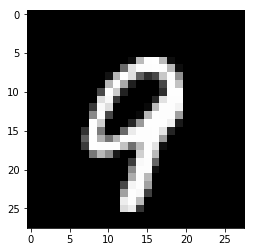

In [8]:
print_image(t.X, t.y)

### Split dataset

In [9]:
t.X_train, t.X_test, t.y_train, t.y_test = \
    train_test_split(t.X, t.y, test_size=0.2)

In [10]:
t.X_train.shape, t.X_test.shape, t.y_train.shape, t.y_test.shape

((56000, 28, 28), (14000, 28, 28), (56000,), (14000,))

In [11]:
t.X_train.shape

(56000, 28, 28)

### Intro to Pytorch

In [12]:
a = torch.Tensor(np.array([1, 2, 3, 3, 3, 5]))
a = torch.Tensor(np.random.randn(2, 3))
a

tensor([[ 2.0007,  0.5610, -1.0837],
        [-0.4191,  0.6625, -0.9281]])

In [13]:
torch.max(a, dim=1)

torch.return_types.max(
values=tensor([2.0007, 0.6625]),
indices=tensor([0, 1]))

In [14]:
a[1:7]

tensor([[-0.4191,  0.6625, -0.9281]])

Softmax normalizes a vector of K numbers into a probability distribution proportional to the exponents - a categorical distribution, i.e. a distribution over K possible outcomes.

In [15]:
torch.softmax(torch.Tensor([-1, 2.5, 0.5]), dim=0)

tensor([0.0259, 0.8580, 0.1161])

In [16]:
t.device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
t.device

device(type='cuda')

In [17]:
torch.Tensor([1, 2, 3]).to(t.device)

tensor([1., 2., 3.], device='cuda:0')

### Convert data

In [18]:
t.X_train_t = torch.from_numpy(np.expand_dims(t.X_train, axis=1)).to(t.device)
t.X_test_t = torch.from_numpy(np.expand_dims(t.X_test, axis=1)).to(t.device)
t.y_train_t = torch.from_numpy(t.y_train).to(t.device)
t.y_test_t = torch.from_numpy(t.y_test).to(t.device)

In [19]:
t.y_train_t

tensor([9, 3, 4,  ..., 1, 4, 7], device='cuda:0')

## Training!

## Explain gradient and training

1. Loss function is a function.
1. Forward pass.
1. Calculate output -> error.
1. Gradient of a loss function gives how we should update weights.

In [20]:
def accuracy(y_pred_one_hot, y_true):
    y_pred = y_pred_one_hot.max(dim=1)[1]
    return (y_pred == y_true).sum().item() / y_true.shape[0]

## LetNet

Gradient-Based Learning Applied to Document Recognition<br>
Yann Lecun, Leon Bottou, Yoshua Bengio, Patrick Haffner<br>
Proceedings of the IEEE 86(11):2278 - 2324 · December 1998 with 31,513 Reads<br>
https://www.researchgate.net/publication/2985446_Gradient-Based_Learning_Applied_to_Document_Recognition


```
"Layer C1 is a convolutional layer with six feature maps.
Each unit in each feature map is connected to a 5 5 neighborhood 
in the input. The size of the feature maps is 28 28 which prevents 
connection from the input from falling off the boundary. C1 contains 
156 trainable parameters and 122 304 connections.

Layer S2 is a subsampling layer with six feature maps of
size 14 14. Each unit in each feature map is connected to a
2 2 neighborhood in the corresponding feature map in C1.
The four inputs to a unit in S2 are added, then multiplied by 
a trainable coefficient, and then added to a trainable bias.
The result is passed through a sigmoidal function. 
The 2 2 receptive fields are nonoverlapping, therefore feature maps
in S2 have half the number of rows and column as feature
maps in C1. Layer S2 has 12 trainable parameters and 5880
connections.

Layer C3 is a convolutional layer with 16 feature maps.
Each unit in each feature map is connected to several
5 5 neighborhoods at identical locations in a subset of
S2’s feature maps.

[...]

Layer S4 is a subsampling layer with 16 feature maps of
size 5 5. Each unit in each feature map is connected to a
2 2 neighborhood in the corresponding feature map in C3,
in a similar way as C1 and S2. Layer S4 has 32 trainable
parameters and 2000 connections.

Layer C5 is a convolutional layer with 120 feature maps.
Each unit is connected to a 5 5 neighborhood on all 16
of S4’s feature maps. Here, because the size of S4 is also
5 5, the size of C5’s feature maps is 1 1; this amounts
to a full connection between S4 and C5. C5 is labeled as
a convolutional layer, instead of a fully connected layer,
because if LeNet-5 input were made bigger with everything
else kept constant, the feature map dimension would be
larger than 1 1.

Layer F6 contains 84 units (the reason for this number
comes from the design of the output layer, explained
below) and is fully connected to C5. It has 10 164 trainable
parameters.
"

```

In [21]:
from torch import nn

def create_lenet_classic():
    return nn.Sequential(
        # C1: 28 x 28 x 1
        nn.Conv2d(1, 6, kernel_size=5, stride=1),
        nn.ReLU(),
        # S2: 28 x 28 x 6
        nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0),
        # C3: 14 x 14 x 6
        nn.Conv2d(6, 16, kernel_size=5, stride=1),
        nn.ReLU(),
        # S4: 10 x 10 x 16
        nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0),
        # C5: 5 x 5 x 16
        nn.Conv2d(16, 120, kernel_size=5, stride=1),
        nn.ReLU(),
        
        nn.Flatten(),
        
        nn.Linear(120, 84),
        nn.ReLU(),
        
        nn.Linear(84, 10),
        nn.LogSoftmax(dim=-1),
    )

### Training Step

In [22]:
loop = Object()

In [23]:
loop.model = create_lenet_classic().to(t.device)

In [24]:
loop.loss = nn.NLLLoss()

In [25]:
loop.output = loop.model(t.X_train_t.to(t.device))

RuntimeError: Calculated padded input size per channel: (4 x 4). Kernel size: (5 x 5). Kernel size can't be greater than actual input size

In [26]:
t.X.shape

(70000, 28, 28)

### Resize Images

In [27]:
if t.X.shape[1] < 32:
    t.X = np.pad(t.X, (
            (0, 0),
            (2, 2),
            (2, 2)),
          mode='constant')

In [28]:
t.X.shape

(70000, 32, 32)

2


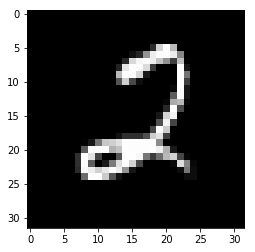

In [29]:
print_image(t.X, t.y)

### Recreate Set
Since we changed the source data format, we need to recreate out training, test and Tensor sets.

In [30]:
t.X_train, t.X_test, t.y_train, t.y_test = \
    train_test_split(t.X, t.y, test_size=0.2)

In [31]:
t.X_train_t = torch.from_numpy(np.expand_dims(t.X_train, axis=1)).to(t.device)
t.X_test_t = torch.from_numpy(np.expand_dims(t.X_test, axis=1)).to(t.device)
t.y_train_t = torch.from_numpy(t.y_train).to(t.device)
t.y_test_t = torch.from_numpy(t.y_test).to(t.device)

In [32]:
t.X_test_t.shape

torch.Size([14000, 1, 32, 32])

### Continue Manual Train Step

In [33]:
loop = Object()

In [34]:
loop.model = create_lenet_classic().to(t.device)

In [35]:
loop.loss = nn.NLLLoss()

In [36]:
loop.opt = torch.optim.SGD(
    loop.model.parameters(),
    lr=1e-3,
    momentum=0.9, 
    nesterov=True)

In [37]:
loop.outputs = loop.model(t.X_train_t)

In [38]:
loop.loss_value = loop.loss(loop.outputs, t.y_train_t)
loop.loss_value

tensor(6.4921, device='cuda:0', grad_fn=<NllLossBackward>)

In [39]:
loop.model.zero_grad()

In [40]:
loop.loss_value.backward()

In [41]:
loop.opt.step()

### Training Loop

In [42]:
loop = None

In [43]:
# t.learning_rate = 1e-4
t.loss = torch.nn.NLLLoss()

In [55]:
def train_batch(net, data, epochs=3):
    optim = torch.optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, nesterov=True)
    batch_size = 16
    batches = int(data.X_train_t.shape[0] / batch_size)
    print_every = batches / 10
    
    for i in range(epochs):
        for b in range(batches):
            start = b * batch_size
            end = start + batch_size
            x_batch = data.X_train_t[start : end]
            y_batch = data.y_train_t[start : end]
        
             # Forward pass: compute predicted y by passing x to the model.
            y_pred = net(x_batch.to(t.device))

            # Compute and print loss.
            loss = data.loss(y_pred, y_batch)

            # Reset gradient
            net.zero_grad()

            # Backward pass: compute gradient of the loss with respect to model
            # parameters
            loss.backward()

            # Calling the step function on an Optimizer makes an update to its
            # parameters
            optim.step()

            if b % print_every == 1:
                print(i, b, 
                      "Loss:", loss.item(), 
                      "accuracy: ", accuracy(net(data.X_train_t), 
                                             data.y_train_t))

In [56]:
%%time
t.nn = create_lenet_classic().to(t.device)
train_batch(t.nn, t, epochs=3)

0 1 Loss: 3.950396776199341 accuracy:  0.13833928571428572
0 351 Loss: 0.24746663868427277 accuracy:  0.9483928571428571
0 701 Loss: 0.008135557174682617 accuracy:  0.958
0 1051 Loss: 0.22548530995845795 accuracy:  0.9692142857142857
0 1401 Loss: 0.03447425365447998 accuracy:  0.9744642857142857
0 1751 Loss: 0.25367456674575806 accuracy:  0.9665178571428571
0 2101 Loss: 0.02564561367034912 accuracy:  0.9748928571428571
0 2451 Loss: 0.04089784622192383 accuracy:  0.9769464285714285
0 2801 Loss: 0.172178715467453 accuracy:  0.9774285714285714
0 3151 Loss: 0.006169646978378296 accuracy:  0.9797321428571428
1 1 Loss: 0.022557944059371948 accuracy:  0.9785
1 351 Loss: 0.18995091319084167 accuracy:  0.9832857142857143
1 701 Loss: 0.004425644874572754 accuracy:  0.9856428571428572
1 1051 Loss: 0.05800029635429382 accuracy:  0.9840714285714286
1 1401 Loss: 0.02508699893951416 accuracy:  0.9878392857142857
1 1751 Loss: 0.04808393120765686 accuracy:  0.98425
1 2101 Loss: 0.053099095821380615 acc

### 4. Test on New Data

In [57]:
accuracy(t.nn(t.X_test_t), t.y_test_t)

0.9792857142857143

### Predict a Single Image

In [71]:
t.test_n = np.random.randint(t.X_test.shape[0])
t.test_n, t.X_test[t.test_n].shape

(12782, (32, 32))

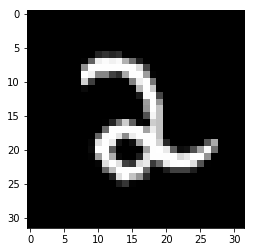

In [72]:
plt.imshow(t.X_test[t.test_n], cmap="gray")

In [73]:
t.test_image = np.expand_dims(np.expand_dims(t.X_test[t.test_n], axis=0), axis=0)
t.test_image.shape

(1, 1, 32, 32)

In [74]:
t.test_image_t = torch.from_numpy(t.test_image)

In [75]:
logits = t.nn(t.test_image_t.to(t.device))
logits

tensor([[-24.6994, -23.3972,   0.0000, -21.2241, -22.7129, -29.0600, -31.3175,
         -20.5472, -24.8224, -29.9565]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)

In [76]:
torch.exp(logits)

tensor([[1.8758e-11, 6.8979e-11, 1.0000e+00, 6.0604e-10, 1.3675e-10, 2.3955e-13,
         2.5060e-14, 1.1925e-09, 1.6587e-11, 9.7740e-14]], device='cuda:0',
       grad_fn=<ExpBackward>)

In [77]:
torch.argmax(torch.exp(logits[0]))

tensor(2, device='cuda:0')

In [88]:
def predict_image(net, x_t, x, y, n=None):
    if n is None:
        n = np.random.randint(x.shape[0])
    image_t = x_t[n]
    pred_t = net(image_t.unsqueeze(0))
    pred = torch.argmax(torch.exp(pred_t[0])).item()
    print(n, ':', y[n], ' : ',  pred)
    plt.imshow(x[n], cmap="gray")

6423 : 0  :  0


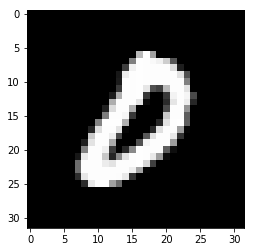

In [111]:
predict_image(t.nn, t.X_test_t, t.X_test, t.y_test)

In [112]:
def find_wrong_image(net, x, y):
    while True:
        n = np.random.randint(x.shape[0])
        image = np.expand_dims(np.expand_dims(x[n], axis=0), axis=0).astype(np.float32)
        image_t = torch.from_numpy(image)
        pred_t = net(image_t)
        pred = torch.argmax(torch.exp(pred_t[0])).item()
        if pred != y[n]:
            print(n, ':', y[n], ' : ',  pred)
            plt.imshow(x[n], cmap="gray")
            break
    return n

1589 : 9  :  4


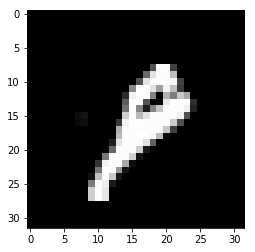

In [122]:
t.wrong_n = find_wrong_image(t.nn.cpu(), t.X_test, t.y_test)

In [123]:
torch.exp(
    t.nn(torch.from_numpy(np.expand_dims(np.expand_dims(t.X_test[t.wrong_n], 0), 0)))
)

tensor([[1.5886e-03, 3.5902e-03, 2.8314e-04, 3.2842e-04, 5.0060e-01, 2.1805e-03,
         2.4678e-04, 6.1624e-02, 6.1787e-02, 3.6777e-01]],
       grad_fn=<ExpBackward>)

## Homework

1. Wire the LeNet-5 to RedisAI and Twitter. Write a digit on your phone, send to your twitter, recognize, post back the prediction.
<br>
<br>
1. Traffic Signs. 
  1. Re-train the network using traffic signs, http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset. Note: convert images to grayscale for this assignment.
  1. Upload to RedisAI. 
  1. Take a picture of the real trafic sign (when safe to do so), post it to your twitter, check the prediction.
<br>
<br>
1. Adapt LeNet-5 to work with RGB color images, and train on full-color images of traffic signs.